## Gaussian Mixture Model

- A good example in Variational Autoencoder before:
http://willcrichton.net/notes/probabilistic-programming-under-the-hood/

In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 71kB 18.6MB/s 
     |████████████████████████████████| 748.9MB 17kB/s 
     |████████████████████████████████| 51kB 10.6MB/s 
  Created wheel for pyro-ppl: filename=pyro_ppl-0.4.0-cp36-none-any.whl size=370752 sha256=cba162fe89628a6926a115aa7e81ceb4d6fde4e3942dafb2ec9d77d9feb51a77
  Stored in directory: /root/.cache/pip/wheels/14/1a/a9/896e3cb73f56729c480545be63fd5073933ed7fe604d4f4e74
  Created wheel for opt-einsum: filename=opt_einsum-3.0.0-cp36-none-any.whl size=58490 sha256=35263479440a70a1a3636be92c438ae07a32b27b4721b11b853a25f6052fd241
  Stored in directory: /root/.cache/pip/wheels/a1/82/aa/e6d68e36a66706a69f890a6072793d2b87730572499c626ed8
Successfully built pyro-ppl opt-einsum
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uni

In [0]:
from __future__ import print_function
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

In [0]:
# tiny dataset with 5 points
data = torch.tensor([0., 1., 10., 11., 12.])

### Training a MAP estimator

In [0]:
K = 2  # Fixed number of components.

# this model will learn global mixture weights, 
# the location of each mixture component, 
# and a shared scale that is common to both components.
@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    #  declare a dimension as independent is to
    # declare the rightmost batch dimension as independent 
    with pyro.plate('components', K):
        # generate two samples each time
        # location of each mixture component
        locs = pyro.sample('locs', dist.Normal(0., 10.))
  
    with pyro.plate('data', len(data)):
        # Local variables.
        # Creates a categorical distribution parameterized by probs here
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

# This implementation of AutoGuide uses Delta distributions 
# to construct a MAP guide over the entire latent space.
# it only requires global variables to be recorded.
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

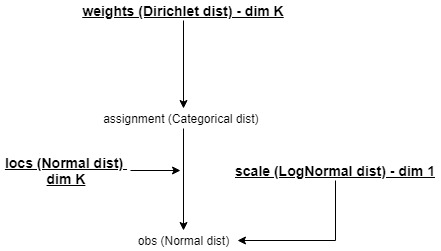

In [0]:
# importing PIL 
from PIL import Image 
Image.open('Gaussian Mixture sample flow.jpg')   
# bold Global v.s non-bold local

In [0]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

### AutoDelta

- This implementation of AutoGuide uses Delta distributions to construct a MAP guide over the entire latent space. 
- By default latent variables are randomly initialized by the model. 

In [0]:
# All default AutoGuide in Pyro
__all__ = [
    'AutoCallable',
    'AutoContinuous',
    'AutoDelta',
    'AutoDiagonalNormal',
    'AutoDiscreteParallel',
    'AutoGuide',
    'AutoGuideList',
    'AutoIAFNormal',
    'AutoLaplaceApproximation',
    'AutoLowRankMultivariateNormal',
    'AutoMultivariateNormal',
]
 
# Usage:  
# guide = AutoDelta(model); svi = SVI(model, guide, ...)
class AutoDelta(AutoGuide):
    def __call__(self, *args, **kwargs):
        """
        An automatic guide with the same ``*args, **kwargs`` as the base ``model``
        :return: A dict mapping sample site name to sampled value.
        :rtype: dict
        """
        # if we've never run the model before, do so now so we can inspect the model structure
        if self.prototype_trace is None:
            self._setup_prototype(*args, **kwargs)

        plates = self._create_plates()
        result = {}
        for name, site in self.prototype_trace.iter_stochastic_nodes():
            with ExitStack() as stack:
                for frame in site["cond_indep_stack"]:
                    if frame.vectorized:
                        stack.enter_context(plates[frame.name])
                value = pyro.param("{}_{}".format(self.prefix, name), site["value"].detach(),
                                   constraint=site["fn"].support)
                # the sample follows Delta distribution
                result[name] = pyro.sample(name, dist.Delta(value, event_dim=site["fn"].event_dim))
        return result
    
    def median(self, *args, **kwargs):
        """
        Returns the posterior median value of each latent variable.
        :return: A dict mapping sample site name to median tensor.
        :rtype: dict
        """
        return self(*args, **kwargs)

In [0]:
class AutoGuide(object):
    """
    Base class for automatic guides.
    Derived classes must implement the :meth:`__call__` method.
    Auto guides can be used individually or combined in an
    :class:`AutoGuideList` object.
    :param callable model: a pyro model
    :param str prefix: a prefix that will be prefixed to all param internal sites
    """
    def __init__(self, model, prefix="auto"):
        self.master = None
        self.model = model
        self.prefix = prefix
        self.prototype_trace = None
        self._plates = {}

    def __call__(self, *args, **kwargs):
        """
        A guide with the same ``*args, **kwargs`` as the base ``model``.
        :return: A dict mapping sample site name to sampled value.
        :rtype: dict
        """
        raise NotImplementedError

    def sample_latent(*args, **kwargs):
        """
        Samples an encoded latent given the same ``*args, **kwargs`` as the
        base ``model``.
        """
        pass

    def _create_plates(self):
        if self.master is not None:
            return self.master().plates
        return {frame.name: pyro.plate(frame.name, frame.size, dim=frame.dim)
                for frame in sorted(self._plates.values())}

    def _setup_prototype(self, *args, **kwargs):
        # run the model so we can inspect its structure
        self.prototype_trace = poutine.block(poutine.trace(self.model).get_trace)(*args, **kwargs)
        self.prototype_trace = prune_subsample_sites(self.prototype_trace)
        if self.master is not None:
            self.master()._check_prototype(self.prototype_trace)

        self._plates = {}
        for name, site in self.prototype_trace.iter_stochastic_nodes():
            for frame in site["cond_indep_stack"]:
                if frame.vectorized:
                    self._plates[frame.name] = frame
                else:
                    raise NotImplementedError("AutoGuideList does not support sequential pyro.plate")
                    
    def median(self, *args, **kwargs):
        """
        Returns the posterior median value of each latent variable.
        :return: A dict mapping sample site name to median tensor.
        :rtype: dict
        """
        raise NotImplementedError

### Initialization
- Before inference we’ll initialize to plausible values. 
- Mixture models are very succeptible to local modes. A common approach is choose the best among many randomly initializations, where the cluster means are initialized from random subsamples of the data. 
- Since we’re using an AutoDelta guide, we can initialize one param for each variable, where the name is prefixed by “auto_” and the constraint is appropriate for each distribution

In [43]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', (data.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)]);
    loss = svi.loss(model, global_guide, data)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 7, initial_loss = 25.665584564208984


In [44]:
# During training, we’ll collect both losses and gradient norms to monitor convergence. 
# We can do this using PyTorch’s .register_hook() method

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    print(name); print(value)
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))
print(gradient_norms)

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

auto_weights
tensor([-0.6931, -0.6931], requires_grad=True)
auto_scale
tensor(1.4122, requires_grad=True)
auto_locs
tensor([ 1., 10.], requires_grad=True)
defaultdict(<class 'list'>, {})

...................................................................................................
...................................................................................................

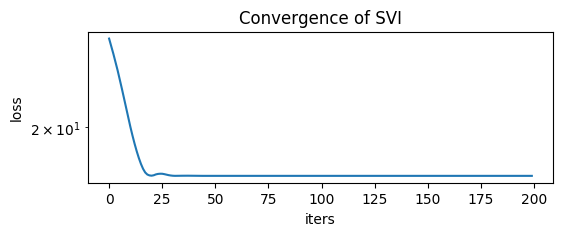

In [32]:
pyplot.figure(figsize=(6,2), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

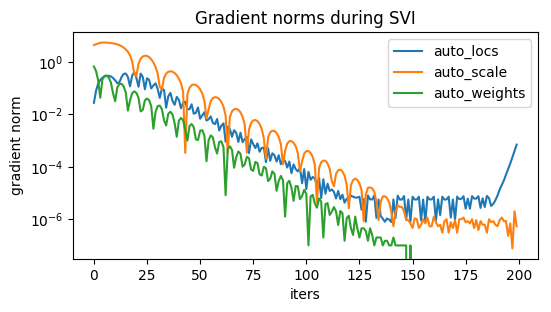

In [45]:
# plot gradient norm for each global variable
pyplot.figure(figsize=(6,3), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [46]:
# Learned parameters
map_estimates = global_guide(data)
print(map_estimates)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

{'weights': tensor([0.3750, 0.6250], grad_fn=<ExpandBackward>), 'scale': tensor(0.6514, grad_fn=<ExpandBackward>), 'locs': tensor([ 0.4987, 10.9845], grad_fn=<ExpandBackward>)}
weights = [0.375 0.625]
locs = [ 0.49867362 10.984463  ]
scale = 0.6514336466789246


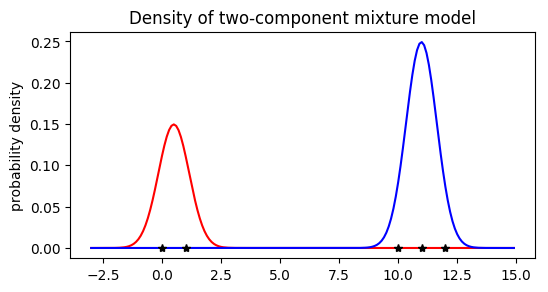

In [47]:
# visualize the mixture model.

X = np.arange(-3,15,0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())

pyplot.figure(figsize=(6, 3), dpi=100).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
# pyplot.plot(X, Y1 + Y2, 'k--')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Density of two-component mixture model')
pyplot.ylabel('probability density');

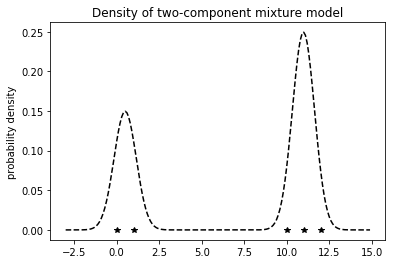

In [36]:
pyplot.plot(X, Y1 + Y2, 'k--')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Density of two-component mixture model')
pyplot.ylabel('probability density');

### Classifier
- During training we marginalized out the assignment variables in the model. While this provides fast convergence, it prevents us from reading the cluster assignments from the guide. 
- We’ll discuss two options for treating the model as a classifier: first using infer_discrete (much faster) and second by training a secondary guide using enumeration inside SVI (slower but more general).

### 1. Predicting membership using discrete inference

In [48]:
# pre-knowledge for partial funcition:
# Partial functions allow one to derive a function with x parameters to a function 
# with fewer parameters and fixed values set for the more limited function.

#Following is the exercise, function provided:
from functools import partial
def func(u,v,w,x):
    return u*4 + v*3 + w*2 + x  
#Enter your code here to create and print with your partial function
dbl = partial(func, 0, 0, 0)
print(dbl(60))

60


In [0]:
"""
Do not run this chunk
"""
# A poutine that samples discrete sites marked with 
# site["infer"]["enumerate"] = "parallel" from the posterior, conditioned on observations.
def infer_discrete(fn=None, first_available_dim=None, temperature=1):
  """
  :param fn: a stochastic function (callable containing Pyro primitive calls)
  :param int first_available_dim: The first tensor dimension (counting
     from the right) that is available for parallel enumeration. This
     dimension and all dimensions left may be used internally by Pyro.
     This should be a negative integer.
  :param int temperature: Either 1 (sample via forward-filter backward-sample)
     or 0 (optimize via Viterbi-like MAP inference). Defaults to 1 (sample).
  """
  assert first_available_dim < 0, first_available_dim
  if fn is None:  # support use as a decorator
    return functools.partial(infer_discrete,
                             first_available_dim=first_available_dim,
                             temperature=temperature)
  return functools.partial(_sample_posterior, fn, first_available_dim, temperature)

@infer_discrete(first_available_dim=-1, temperature=0)
@config_enumerate
def viterbi_decoder(data, hidden_dim=10):
  transition = 0.3 / hidden_dim + 0.7 * torch.eye(hidden_dim)
  means = torch.arange(float(hidden_dim))
  states = [0]
  for t in pyro.markov(range(len(data))):
    states.append(pyro.sample("states_{}".format(t),
                              dist.Categorical(transition[states[-1]])))
    pyro.sample("obs_{}".format(t),
                dist.Normal(means[states[-1]], 1.),obs=data[t])
  return states  # returns maximum likelihood states

In [49]:
guide_trace = poutine.trace(global_guide).get_trace(data)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals

def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["assignment"]["value"]

print(classifier(data))

tensor([0, 0, 1, 1, 1])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


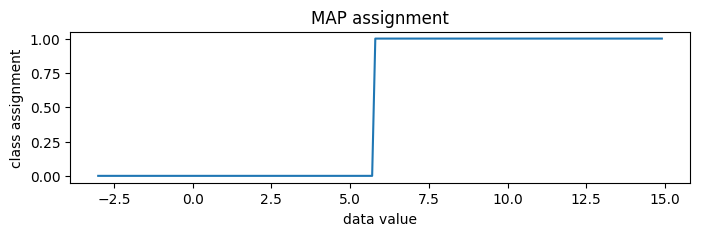

In [50]:
# run this classifer on new data
new_data = torch.arange(-3, 15, 0.1)
assignment = classifier(new_data)
print(assignment)

pyplot.figure(figsize=(8, 2), dpi=100).set_facecolor('white')
pyplot.plot(new_data.numpy(), assignment.numpy())
pyplot.title('MAP assignment')
pyplot.xlabel('data value')
pyplot.ylabel('class assignment');

In [51]:
# To generate random posterior assignments rather than MAP assignments, we could set temperature=1
print(classifier(data, temperature=1))

tensor([0, 0, 1, 1, 1])


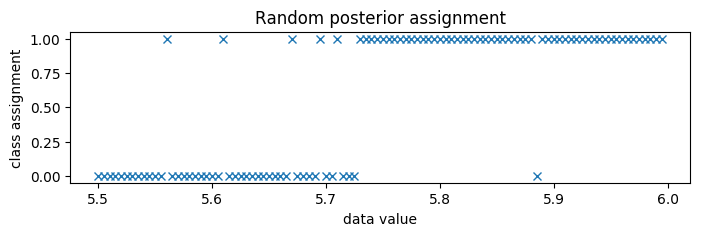

In [52]:
# generate more samples around the separate - 5.75
new_data = torch.arange(5.5, 6.0, 0.005)
assignment = classifier(new_data, temperature=1)
pyplot.figure(figsize=(8, 2), dpi=100).set_facecolor('white')
pyplot.plot(new_data.numpy(), assignment.numpy(), 'bx', color='C0')
pyplot.title('Random posterior assignment')
pyplot.xlabel('data value')
pyplot.ylabel('class assignment');

### 2. Predicting membership by enumerating in the guide

- To read cluster assignments from the guide, we’ll define a new full_guide that fits both global parameters (as above) and local parameters (which were previously marginalized out). 
- Since we’ve already learned good values for the global variables, we will block SVI from updating those by using poutine.block.

In [0]:
@config_enumerate
def full_guide(data):
    # Global variables.
    with poutine.block(hide_types=["param"]):  # Keep our learned values of global parameters.
        global_guide(data)

    # Local variables.
    with pyro.plate('data', len(data)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), K) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Categorical(assignment_probs))

In [73]:
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, full_guide, optim, loss=elbo)

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
svi.loss(model, full_guide, data)  # Initializes param store.
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

In [74]:
for name, value in pyro.get_param_store().named_parameters():
    print(name); print(value)

auto_weights
tensor([-0.9486, -0.4377], requires_grad=True)
auto_scale
tensor(-0.4286, requires_grad=True)
auto_locs
tensor([ 0.4987, 10.9845], requires_grad=True)
assignment_probs
tensor([[  5.3778, -12.7877],
        [  5.3745, -12.7725],
        [-12.7634,   5.3726],
        [-12.7817,   5.3765],
        [-12.7939,   5.3791]], requires_grad=True)


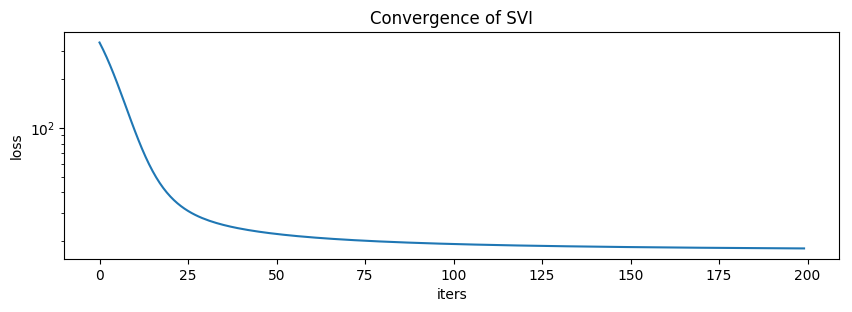

In [55]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

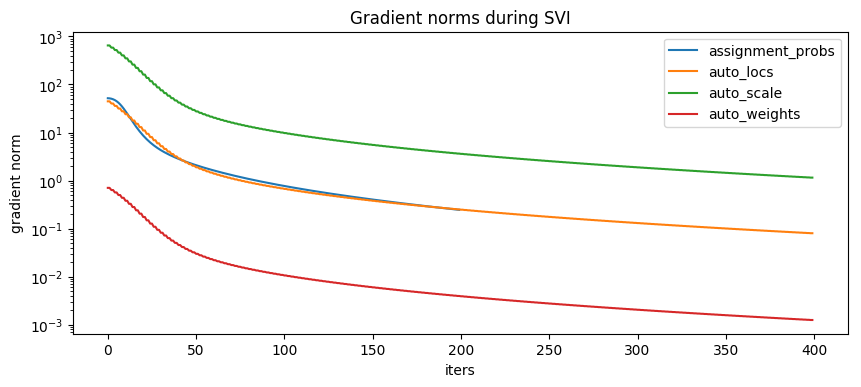

In [56]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

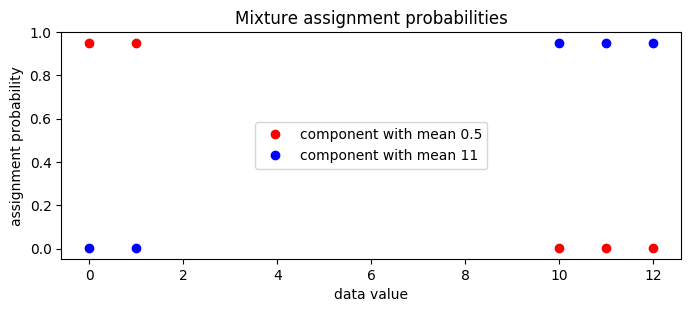

In [59]:
assignment_probs = pyro.param('assignment_probs')
pyplot.figure(figsize=(8, 3), dpi=100).set_facecolor('white')
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 0], 'ro',
            label='component with mean {:0.2g}'.format(locs[0]))
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 1], 'bo',
            label='component with mean {:0.2g}'.format(locs[1]))
pyplot.title('Mixture assignment probabilities')
pyplot.xlabel('data value')
pyplot.ylabel('assignment probability')
pyplot.legend(loc='center');

### MCMC
- Next we’ll explore the full posterior over component parameters using collapsed NUTS, i.e. we’ll use NUTS and marginalize out all discrete latent variables.

In [60]:
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

pyro.set_rng_seed(2)

# NUTS here:
# No-U-Turn Sampler kernel, which provides an efficient and convenient way
# to run Hamiltonian Monte Carlo
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=250, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 300/300 [00:32<00:00, 15.18it/s, step size=6.53e-02, acc. prob=0.946]


In [0]:
class MCMC(TracePosterior):
    """
    Wrapper class for Markov Chain Monte Carlo algorithms. Specific MCMC algorithms
    are TraceKernel instances and need to be supplied as a ``kernel`` argument
    to the constructor.

    :param kernel: An instance of the ``TraceKernel`` class, which when
        given an execution trace returns another sample trace from the target
        (posterior) distribution.
    :param int num_samples: The number of samples that need to be generated,
        excluding the samples discarded during the warmup phase.
    :param int warmup_steps: Number of warmup iterations. The samples generated
        during the warmup phase are discarded.
    """

    def __init__(self, kernel, num_samples, warmup_steps=0):
        self.kernel = kernel
        self.warmup_steps = warmup_steps
        self.num_samples = num_samples
        self.logger = logging.getLogger(__name__)
        super(MCMC, self).__init__()

    def _traces(self, *args, **kwargs):
        self.kernel.setup(*args, **kwargs)
        trace = self.kernel.initial_trace()
        self.logger.info("Starting MCMC using kernel - {} ...".format(self.kernel.__class__.__name__))
        logging_interval = math.ceil((self.warmup_steps + self.num_samples) / 20)
        for t in range(1, self.warmup_steps + self.num_samples + 1):
            trace = self.kernel.sample(trace)
            if t % logging_interval == 0:
                stage = "WARMUP" if t <= self.warmup_steps else "SAMPLE"
                self.logger.info("Iteration: {} [{}]".format(t, stage))
                diagnostic_info = self.kernel.diagnostics()
                if diagnostic_info is not None:
                    self.logger.info(diagnostic_info)
            if t <= self.warmup_steps:
                if t == self.warmup_steps:
                    self.kernel.end_warmup()
                continue
            yield (trace, 1.0)
        self.kernel.cleanup()

In [68]:
# posterior_samples has samples for all global variables above
posterior_samples.keys()

dict_keys(['weights', 'scale', 'locs'])

In [0]:
X, Y = posterior_samples["locs"].t()

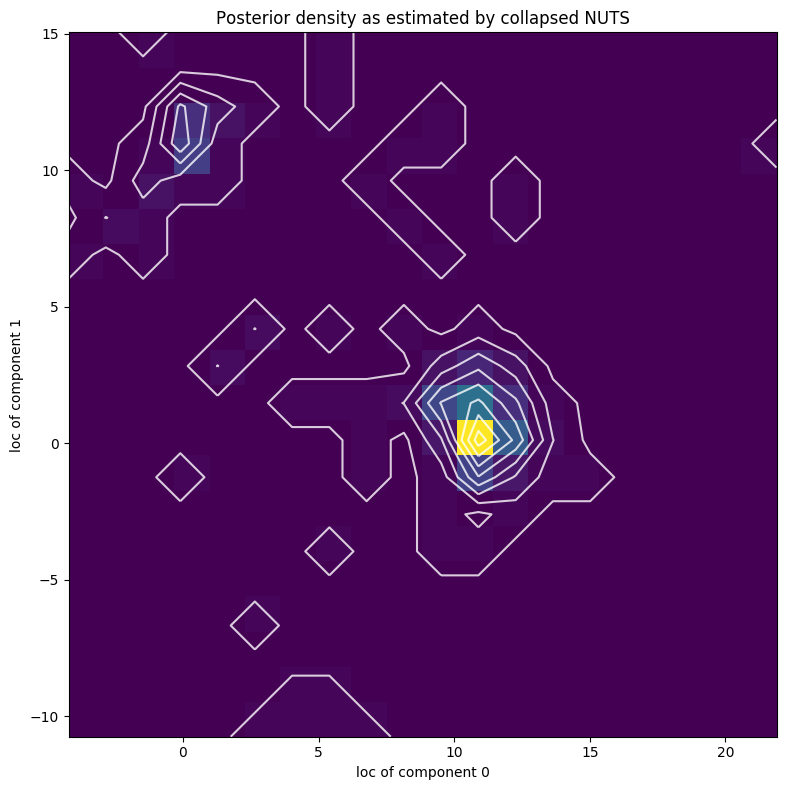

In [72]:
pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
h, xs, ys, image = pyplot.hist2d(X.numpy(), Y.numpy(), bins=[20, 20])
pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
               colors='white', alpha=0.8)
pyplot.title('Posterior density as estimated by collapsed NUTS')
pyplot.xlabel('loc of component 0')
pyplot.ylabel('loc of component 1')
pyplot.tight_layout()

- Note that due to nonidentifiability of the mixture components the likelihood landscape has two equally likely modes, near (11,0.5) and (0.5,11). NUTS has difficulty switching between the two modes.

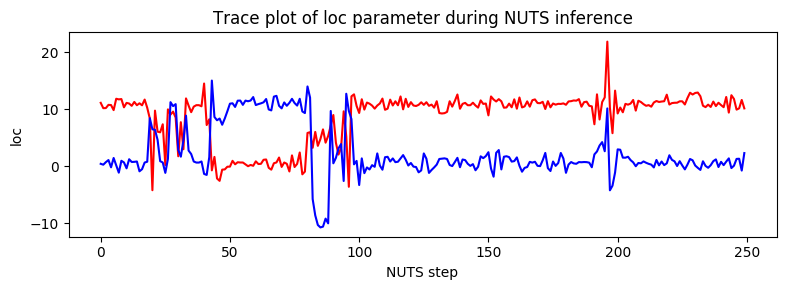

In [65]:
pyplot.figure(figsize=(8, 3), dpi=100).set_facecolor('white')
pyplot.plot(X.numpy(), color='red')
pyplot.plot(Y.numpy(), color='blue')
pyplot.xlabel('NUTS step')
pyplot.ylabel('loc')
pyplot.title('Trace plot of loc parameter during NUTS inference')
pyplot.tight_layout()